### Imports 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm 

### Reading Files and Processing

In [2]:
# Count lines
file_path = "../../data/raw/lichess_eval/lichess_db_eval.jsonl"

print(f"Processing file: {file_path}")
STOP_NUMBER = 1000000
total_lines = 0
with open(file_path, 'r') as file:
    for _ in file:
        if total_lines >= STOP_NUMBER:
            break
        total_lines += 1

print(f"Total lines to process: {total_lines}")



Processing file: ../../data/raw/lichess_eval/lichess_db_eval.jsonl
Total lines to process: 1000000


In [3]:
processed_data = []
total_lines = 0
with open(file_path, 'r') as file:
    
    for line in tqdm(file, total=total_lines, desc="Processing lines"):
        total_lines += 1
        if total_lines >= STOP_NUMBER:
            break
        try:
            obj = json.loads(line.strip())
            fen = obj.get('fen')
            
            cp = None
            # Extract cp from first pvs item
            if obj.get('evals') and len(obj['evals']) > 0:
                if obj['evals'][0].get('pvs') and len(obj['evals'][0]['pvs']) > 0:
                    cp_value = obj['evals'][0]['pvs'][0].get('cp')
                    if cp_value is not None: # Ensure cp_value itself is not None
                        cp = int(cp_value) # Convert cp to integer if it's not None

            # Only append if cp is not None 
            if cp is not None:
                processed_data.append({'fen': fen, 'cp': cp})
        except json.JSONDecodeError:
            print(f"Skipping line due to JSON decode error: {line.strip()}")
        except Exception as e:
            print(f"Skipping line due to other error: {e} - Line: {line.strip()}")


# Create DataFrame from the processed data
df = pd.DataFrame(processed_data)

print(f"\nFinished processing.")
print(f"Total entries processed and kept: {len(df)}")

Processing lines: 999999it [00:14, 67399.06it/s]



Finished processing.
Total entries processed and kept: 829355


### Save df to file

In [4]:
if not df.empty:
    output_file_path = '../../data/interim/lichess_eval/lichess_db_eval.parquet'
    df.to_parquet(output_file_path)
    print(f"\nDataFrame saved to {output_file_path}")
else:
    print("DataFrame is empty. Nothing to save.")


DataFrame saved to ../../data/interim/lichess_eval/lichess_db_eval.parquet


### Simple EDA

In [5]:
if not df.empty:
    print("First 5 entries of the DataFrame:")
    print(df.head())
    
    print("\nDescriptive statistics for 'cp' column:")
    print(df['cp'].describe())
    
    # Check for NaN values in 'cp' column if any slipped through (shouldn't with the logic)
    print(f"\nNumber of NaN values in 'cp' column: {df['cp'].isnull().sum()}")
else:
    print("DataFrame is empty. No data was processed or kept.")

First 5 entries of the DataFrame:
                                                 fen  cp
0       7r/1p3k2/p1bPR3/5p2/2B2P1p/8/PP4P1/3K4 b - -  69
1              8/4r3/2R2pk1/6pp/3P4/6P1/5K1P/8 b - -   0
2  r1b2rk1/1p2bppp/p1nppn2/q7/2P1P3/N1N5/PP2BPPP/...  26
3  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  19
4                    8/8/2N2k2/8/1p2p3/p7/K7/8 b - -   0

Descriptive statistics for 'cp' column:
count    829355.000000
mean        167.659234
std        1538.005510
min      -20000.000000
25%         -20.000000
50%          15.000000
75%          92.000000
max       20000.000000
Name: cp, dtype: float64

Number of NaN values in 'cp' column: 0


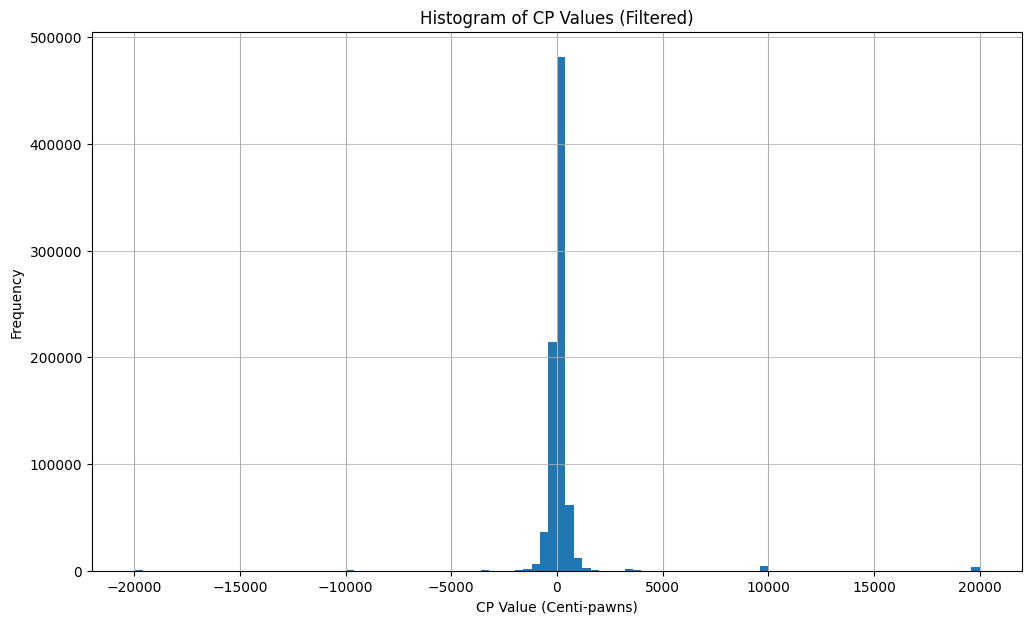

In [6]:
if not df.empty and 'cp' in df.columns and not df['cp'].empty:
    plt.figure(figsize=(12, 7))
    df['cp'].hist(bins=100) # Increased bins for potentially more detail
    plt.title('Histogram of CP Values (Filtered)')
    plt.xlabel('CP Value (Centi-pawns)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("Cannot plot histogram: DataFrame is empty or 'cp' column is missing/empty.")